In [1]:
dataset <- "ARPAPiemonte"
merging_datasets <- c(dataset, "SCIA", "ISAC")
state <- "Piemonte"
match_dist <- 7000
new_dataset <- "PIE"


In [2]:
setwd(fs::path_abs("~/Local_Workspace/TesiMag"))
library(arrow, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)

source("src/database/tools.R")
source("src/database/insert.R")
source("src/database/write.R")
source("src/database/startup.R")
source("src/database/plot.R")
source("src/database/query/spatial.R")
source("src/database/query/data.R")
source("src/merging/analysis.R")
source("src/merging/display.R")
source("src/merging/combining.R")
source("src/merging/tagging.R")
source("notebooks/ds_regionali/procedure/common_steps.R")

conns <- load_dbs()
state_boundaries <- query_boundary(conns$stations, state, "state")


Linking to GEOS 3.11.0, GDAL 3.5.3, PROJ 9.1.0; sf_use_s2() is TRUE



In [3]:
ds_meta <- query_checkpoint_meta(dataset, "qc1", conns$data) |>
    collect()
nat_meta <- query_checkpoint_meta(c("SCIA", "ISAC"), "qc1", conns$data) |>
    filter(!(dataset == "SCIA" & sensor_key %in% c(1868L, 1331L))) |> # Levaldigi é da buttare, Domodossola sono molto strane
    collect() |>
    st_md_to_sf() |>
    st_filter(state_boundaries, .predicate = st_is_within_distance, dist = 1000) |>
    st_drop_geometry() |>
    filter(!state %in% c("Valle D'Aosta", "Liguria", "Lombardia", "Emilia-Romagna"))
metadata <- bind_rows(ds_meta, nat_meta) |>
    arrange(dataset, sensor_key) |>
    mutate(key = row_number()) |>
    filter((dataset == "ARPAPiemonte" & state == "Piemonte") | dataset != "ARPAPiemonte")
metadata_db <- copy_to(conns$data, metadata, "metas_tmp", overwrite = TRUE)

sensor_matches <- close_matches(metadata_db, match_dist, conns$stations)

data <- query_checkpoint_data(merging_datasets, "qc1", conns$data) |>
    filter(valid) |>
    inner_join(metadata_db |> select(dataset, sensor_key, key), by = c("dataset", "sensor_key")) |>
    select(!c(starts_with("qc_"), valid))

var_matches <- series_matches(data, sensor_matches, metadata_db)


In [4]:
analysis <- series_matches_analysis(var_matches, data, metadata_db, matches_offsets = c(-1L, 0L, 1L))
analysis |> write_xlsx_analysis(file.path("notebooks", "ds_regionali", state, "raw_analysis.xlsx"))
# analysis <- read_parquet(file.path("notebooks", "ds_regionali", state, "raw_analysis.parquet"))


In [5]:
source(str_glue("notebooks/ds_regionali/{str_to_lower(state)}/procedures/match_taggers.R"))
tagged_analysis <- analysis |>
    tag_same_series() |>
    default_logic(require_all = FALSE) |>
    tag_manual()

write_xlsx_analysis(tagged_analysis, file.path("notebooks", "ds_regionali", state, "tagged_analysis.xlsx"), starts_with("user_code"), starts_with("tag_"))


In [6]:
gs <- series_groups(tagged_analysis, metadata, data, tag_same_series)
# Dealing with ISAC series
ranked_series_groups <- rank_series_groups(
    gs$table,
    metadata |> mutate(network_prio = if_else(network == "ISAC", 2L, 1L)),
    merging_datasets,
    desc(dataset), desc(sensor_last)
)
ignore_corrections <- make_exclusion_table(tagged_analysis, NULL, network_x == "ISAC" | network_y == "ISAC")
incomp <- incompatible_merges(data, ranked_series_groups, tagged_analysis, 20L, 0.5, ignore_corrections)


In [7]:
i <- incomp |>
    left_join(metadata |> select(key, name, network, dataset, sensor_key), by = c("key_x" = "key")) |>
    left_join(metadata |> select(key, name, network, dataset, sensor_key), by = c("key_y" = "key"), suffix = c("_x", "_y")) |>
    arrange(desc(abs(k0 + 2 * k1 / pi)))
i


pkey,k0,k1,k2,k3,gkey,key_x,key_y,variable,offset_days,name_x,network_x,dataset_x,sensor_key_x,name_y,network_y,dataset_y,sensor_key_y
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<int>
250,0.8405899,-0.156163322,0.22489808,-0.027656234,131,146,473,1,0,LAGO DIETRO LA TORRE,meteorologica,ARPAPiemonte,146,LAGO_DIETRO_LA_TORRE,DPC,ISAC,1664
320,0.8233361,-0.152681552,0.22092781,-0.061717956,166,186,514,1,0,MONVISO,meteorologica,ARPAPiemonte,186,MONVISO,DPC,ISAC,2267
176,0.6524731,0.048670648,0.23364641,-0.078390213,93,105,429,1,0,COLLE DELL'AGNELLO,meteorologica,ARPAPiemonte,105,COLLE_DELL_AGNELLO,DPC,ISAC,1034
382,0.7682021,-0.146012282,0.21861110,-0.002424016,197,223,542,1,0,PIAN GIASSET,meteorologica,ARPAPiemonte,224,PIAN_GIASSET,DPC,ISAC,2616
4,0.8135723,-0.225812477,0.17447066,0.019556963,2,2,328,1,0,ACCEGLIO COLLET,meteorologica,ARPAPiemonte,2,ACCEGLIO_COLLET,DPC,ISAC,11
432,0.5190115,0.144476034,0.19625432,-0.081603736,222,253,354,1,0,RIFUGIO GASTALDI,meteorologica,ARPAPiemonte,254,BALME_RIFUG_GASTALDI,DPC,ISAC,255
72,0.6105044,-0.007725813,0.21731044,-0.059760576,38,43,331,1,0,BOCCHETTA DELLE PISSE,meteorologica,ARPAPiemonte,43,ALAGNA_BOCCHETTA_P,DPC,ISAC,41
48,0.7170956,-0.186726946,0.12551061,0.017482847,80,92,416,1,0,CERESOLE VILLA,meteorologica,ARPAPiemonte,92,CERESOLE_VILLA,DPC,ISAC,895
436,0.5113194,0.110308295,0.17625213,-0.055603659,224,255,570,1,0,RIFUGIO VACCARONE,meteorologica,ARPAPiemonte,256,RIFUGIO_VACCARONE,DPC,ISAC,2974


In [8]:
merge_results <- dynamic_merge(data, ranked_series_groups, metadata, tagged_analysis, rejection_threshold = 100, ignore_corrections, contribution_threshold = -1L)
merged_checkpoint(merge_results, metadata, new_dataset, conns$stations, gs$table)
gc()


,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2177943,116.4,3665794,195.8,NA,3665794,195.8
Vcells,64980314,495.8,185098284,1412.2,16384,301179299,2297.9


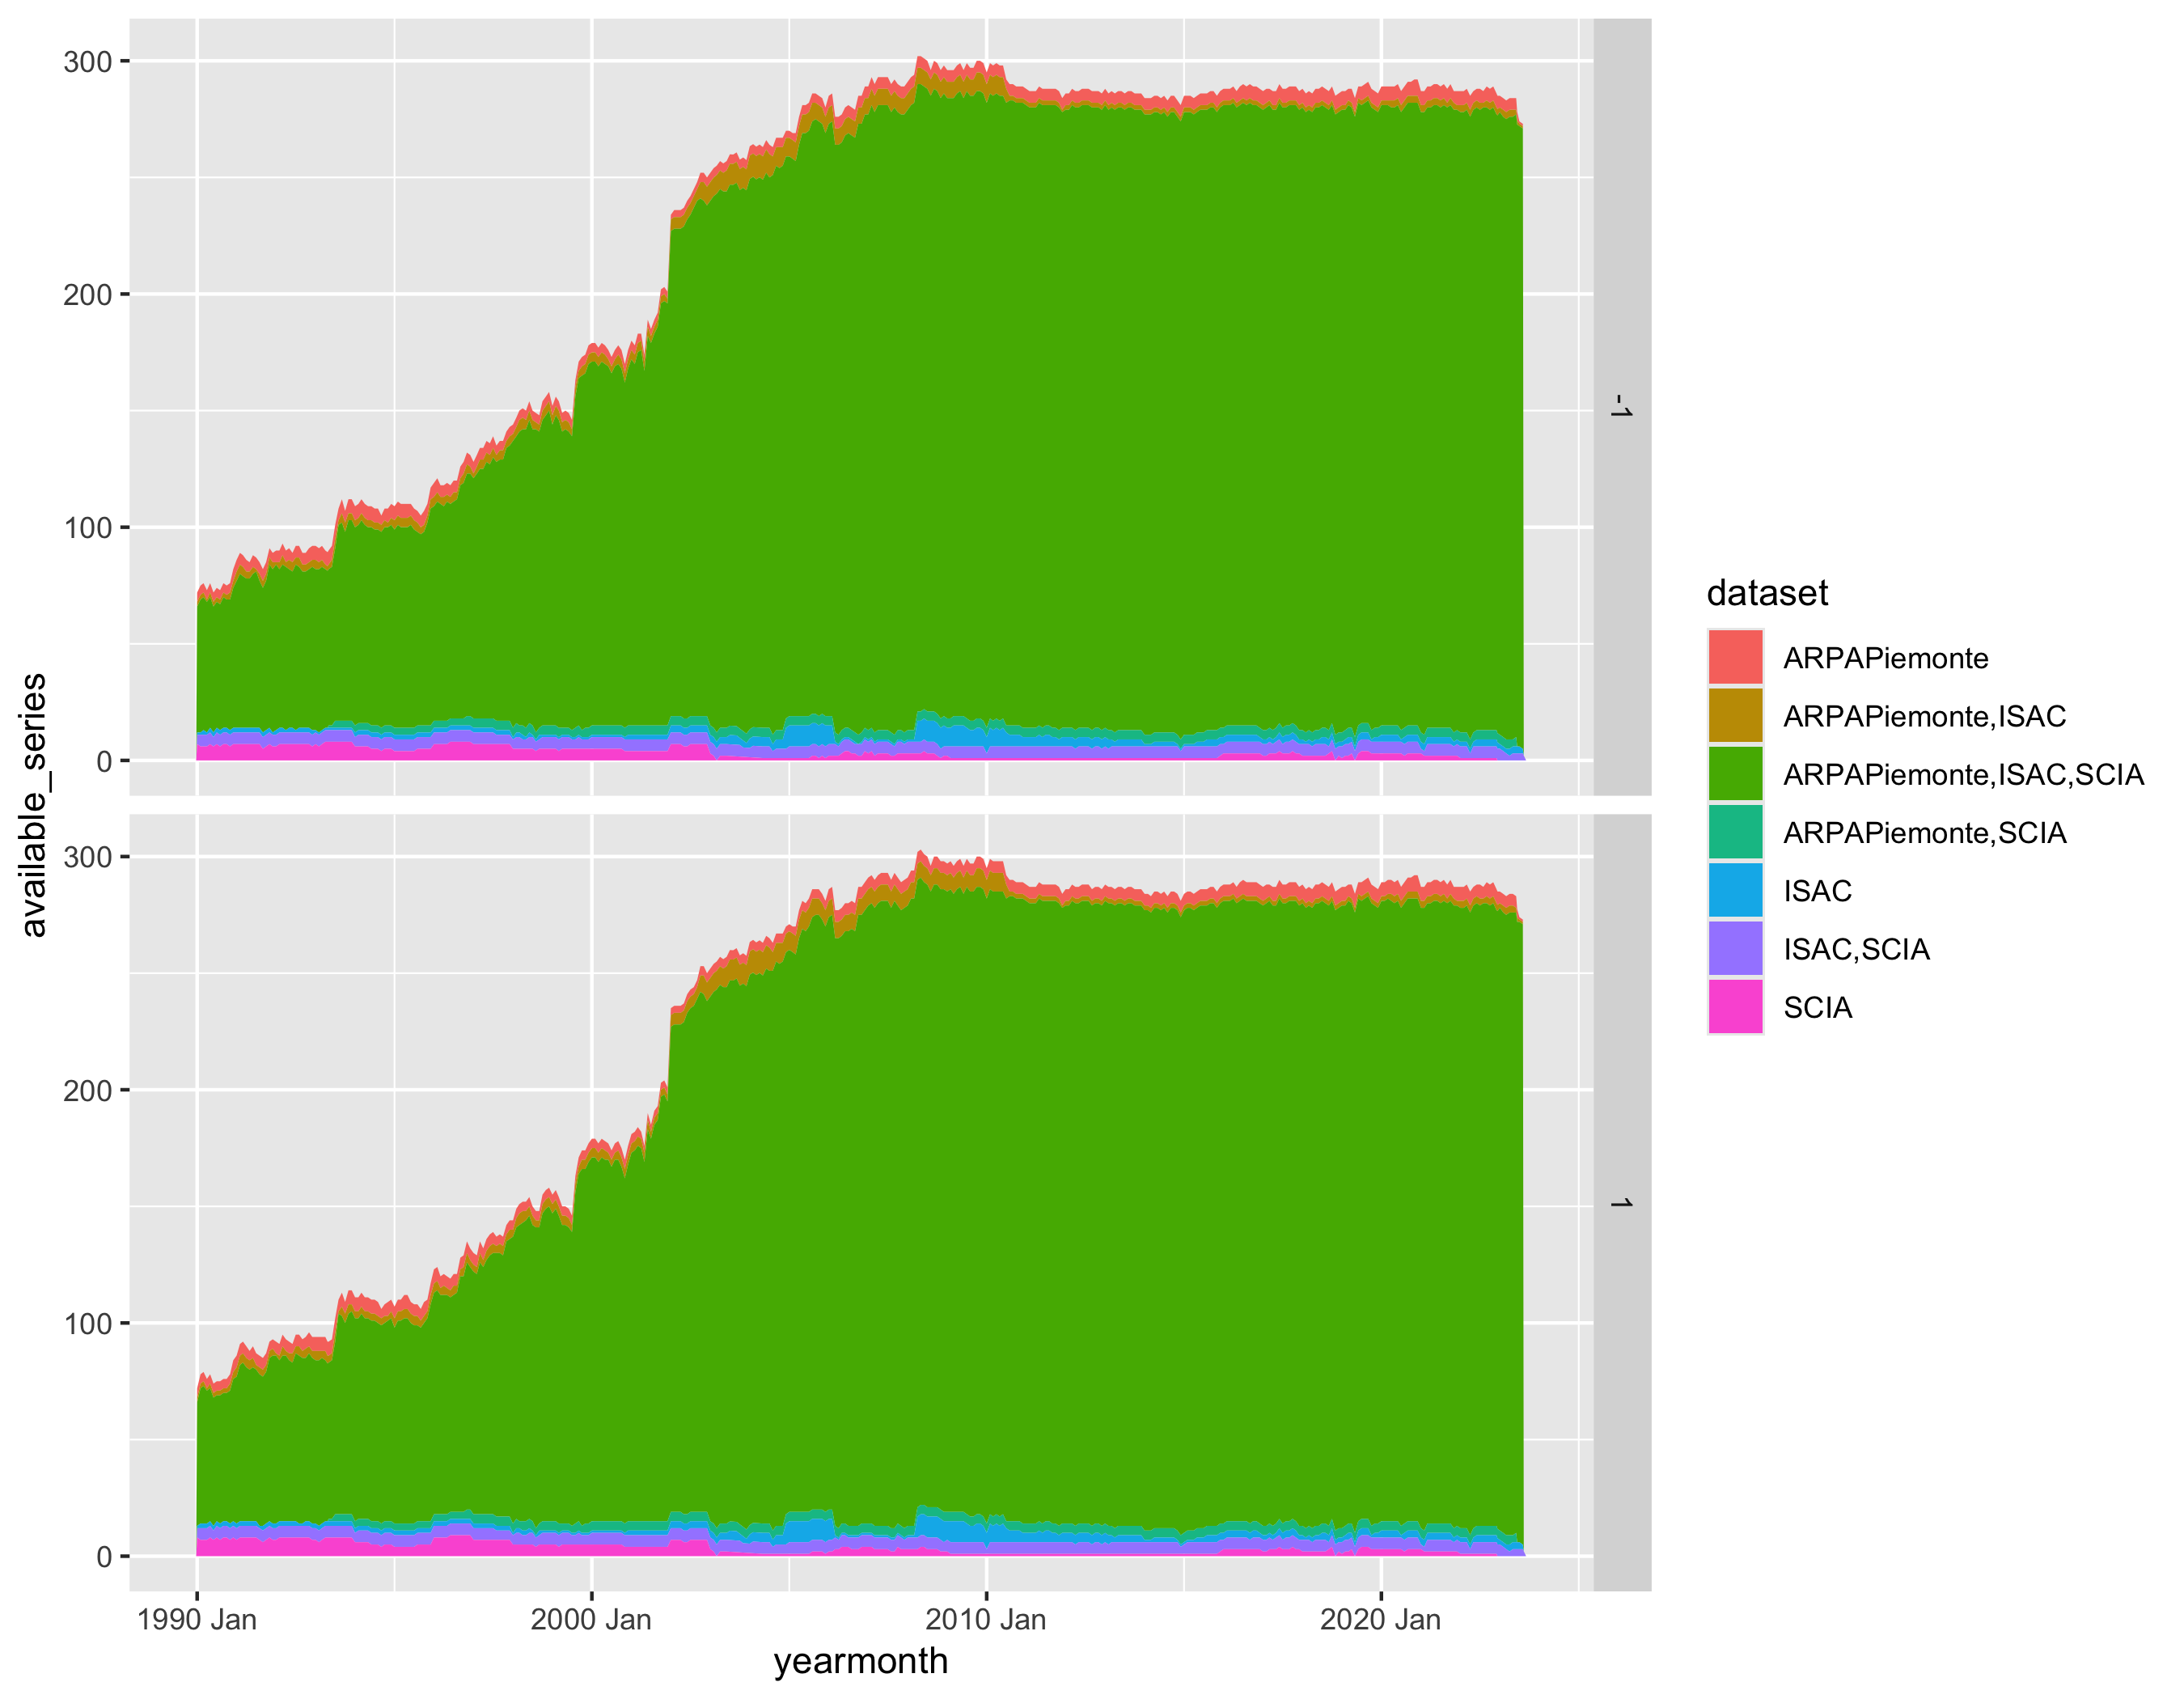

In [9]:
db <- query_checkpoint(new_dataset, "merged", conns$data, all_stations = FALSE)
mt <- db$meta |>
    select(sensor_key, from_datasets) |>
    collect() |>
    rowwise() |>
    mutate(dataset = paste0(from_datasets |> unique() |> sort(), collapse = ",")) |>
    ungroup() |>
    select(-from_datasets)
dt <- db$data |>
    select(-dataset) |>
    left_join(mt, by = "sensor_key", copy = TRUE) |>
    filter(year(date) >= 1990L)
pd <- ymonthly_availabilities(dt, stack = TRUE)
pd$plot + facet_grid(variable ~ .)


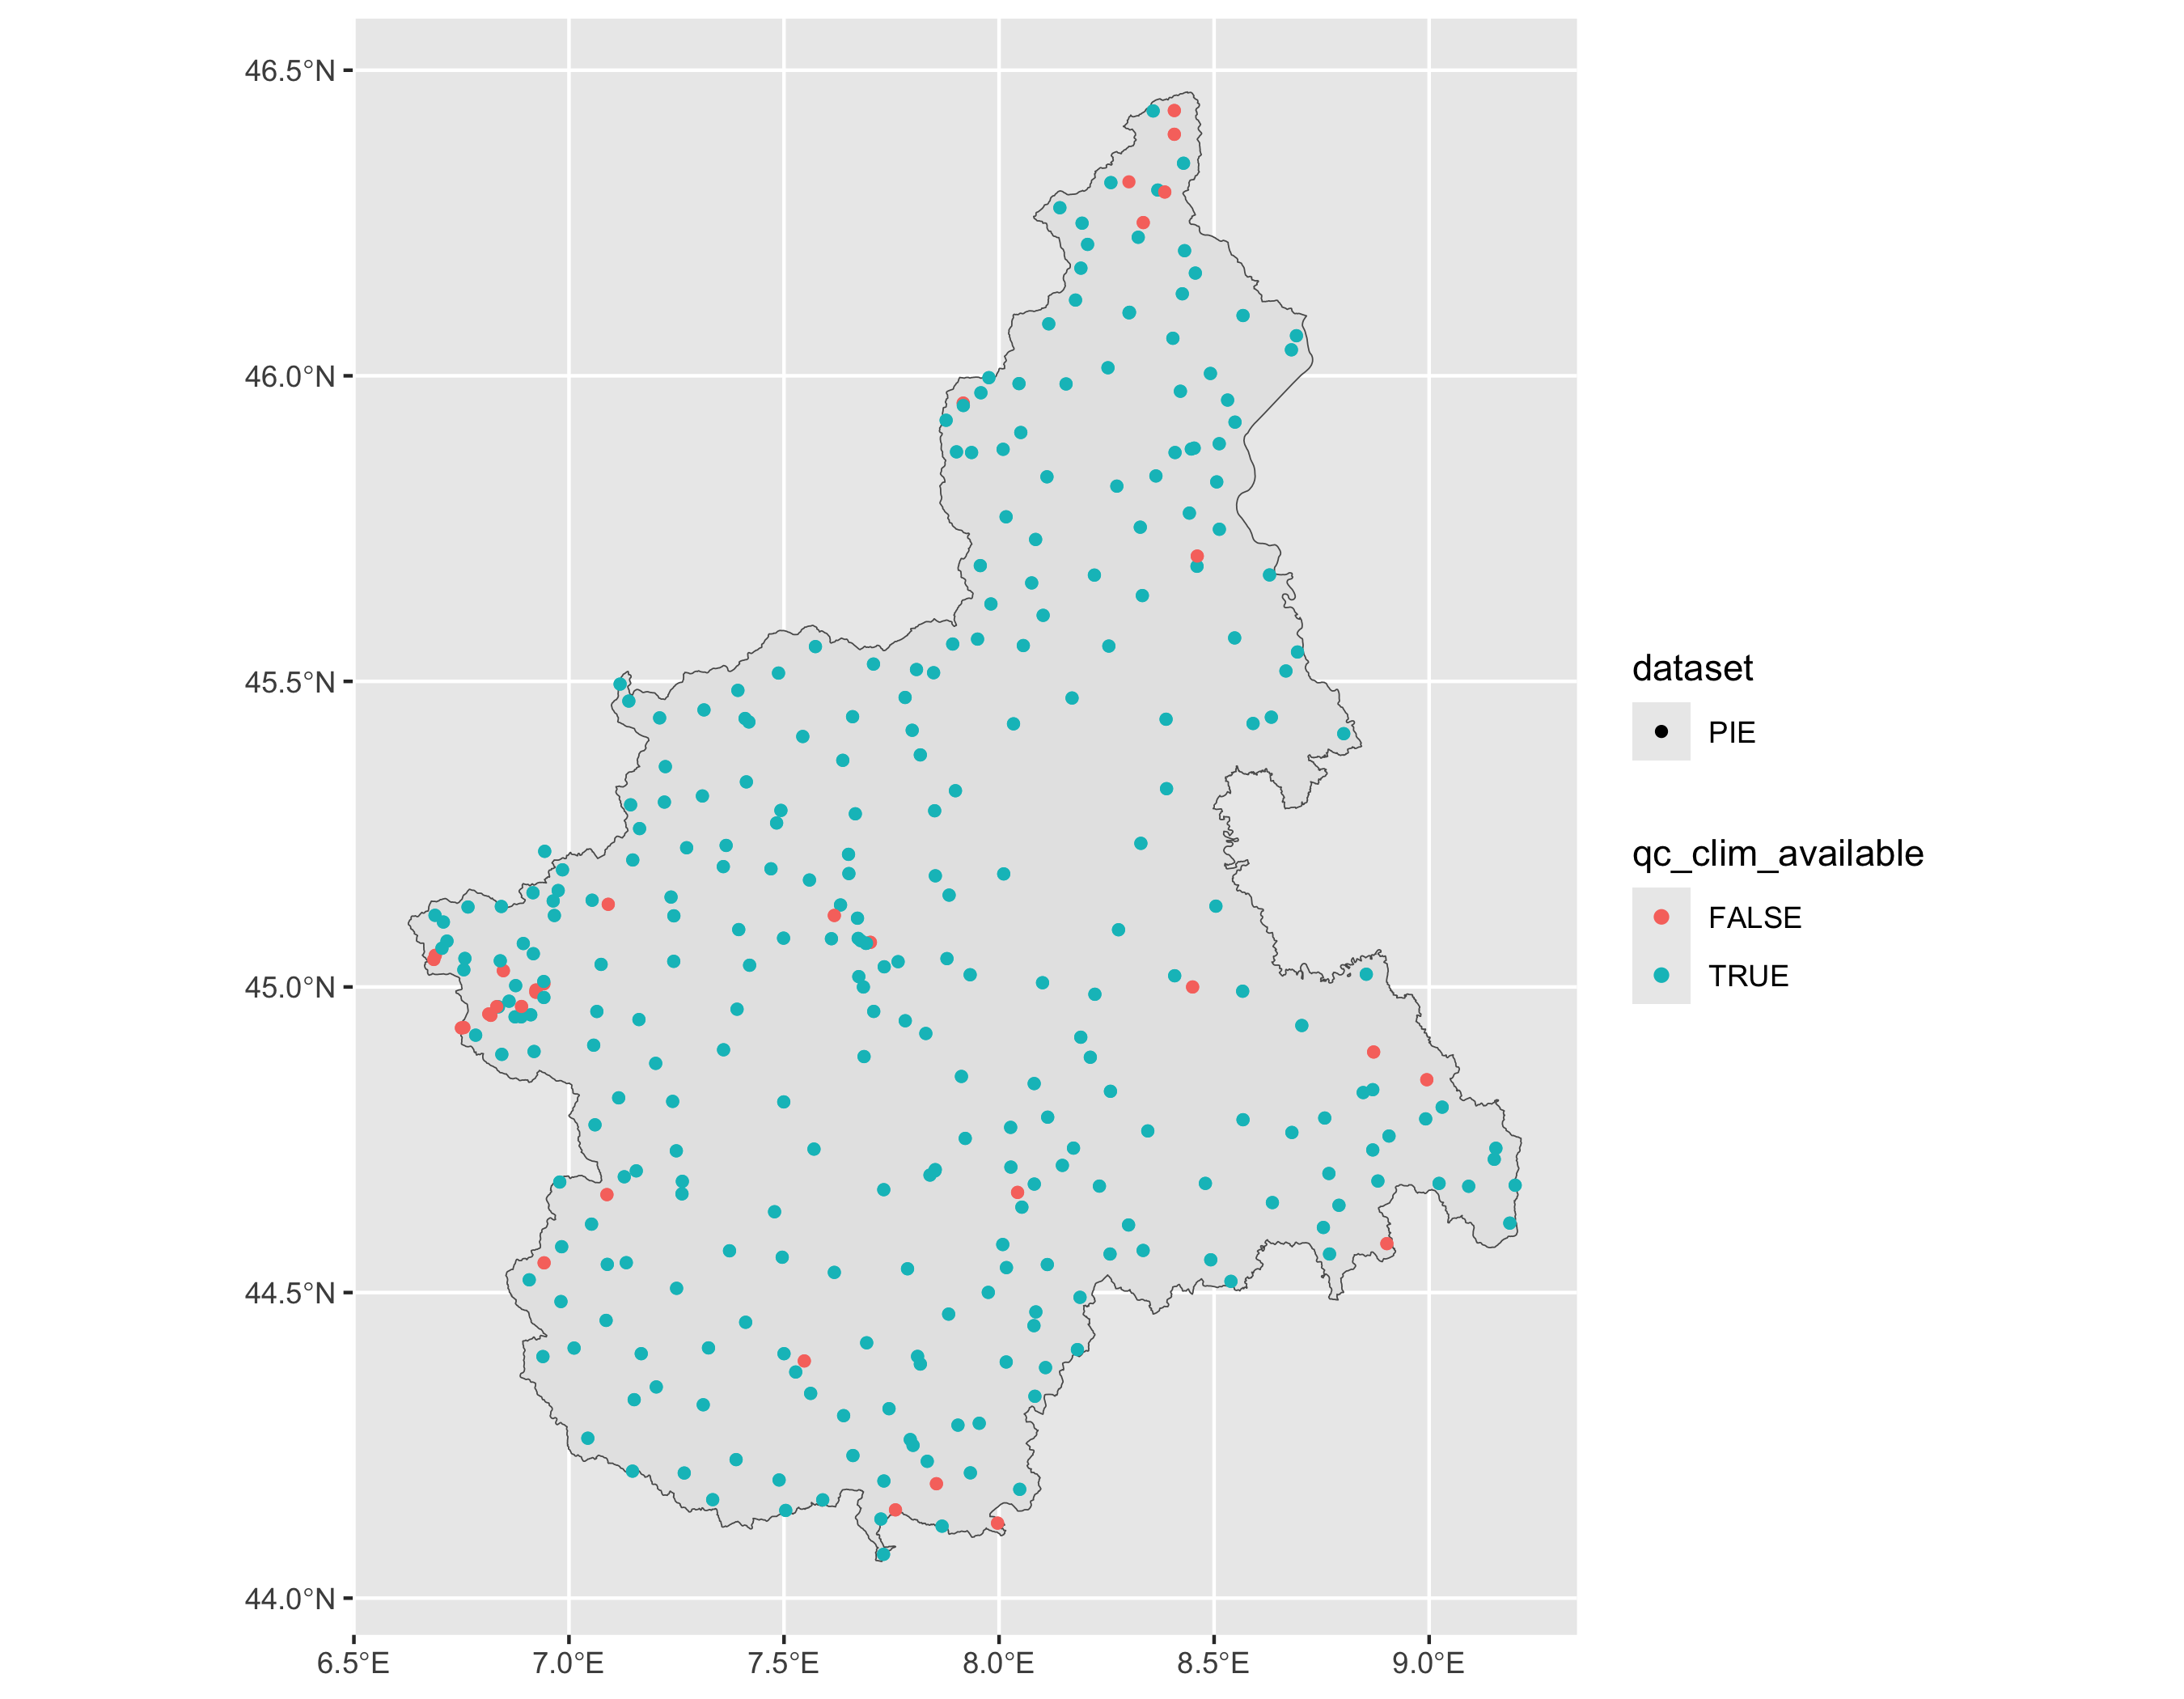

In [10]:
pd <- spatial_availabilities(pd$data |> mutate(dataset = new_dataset), db$meta, state_boundaries)
pd$plot


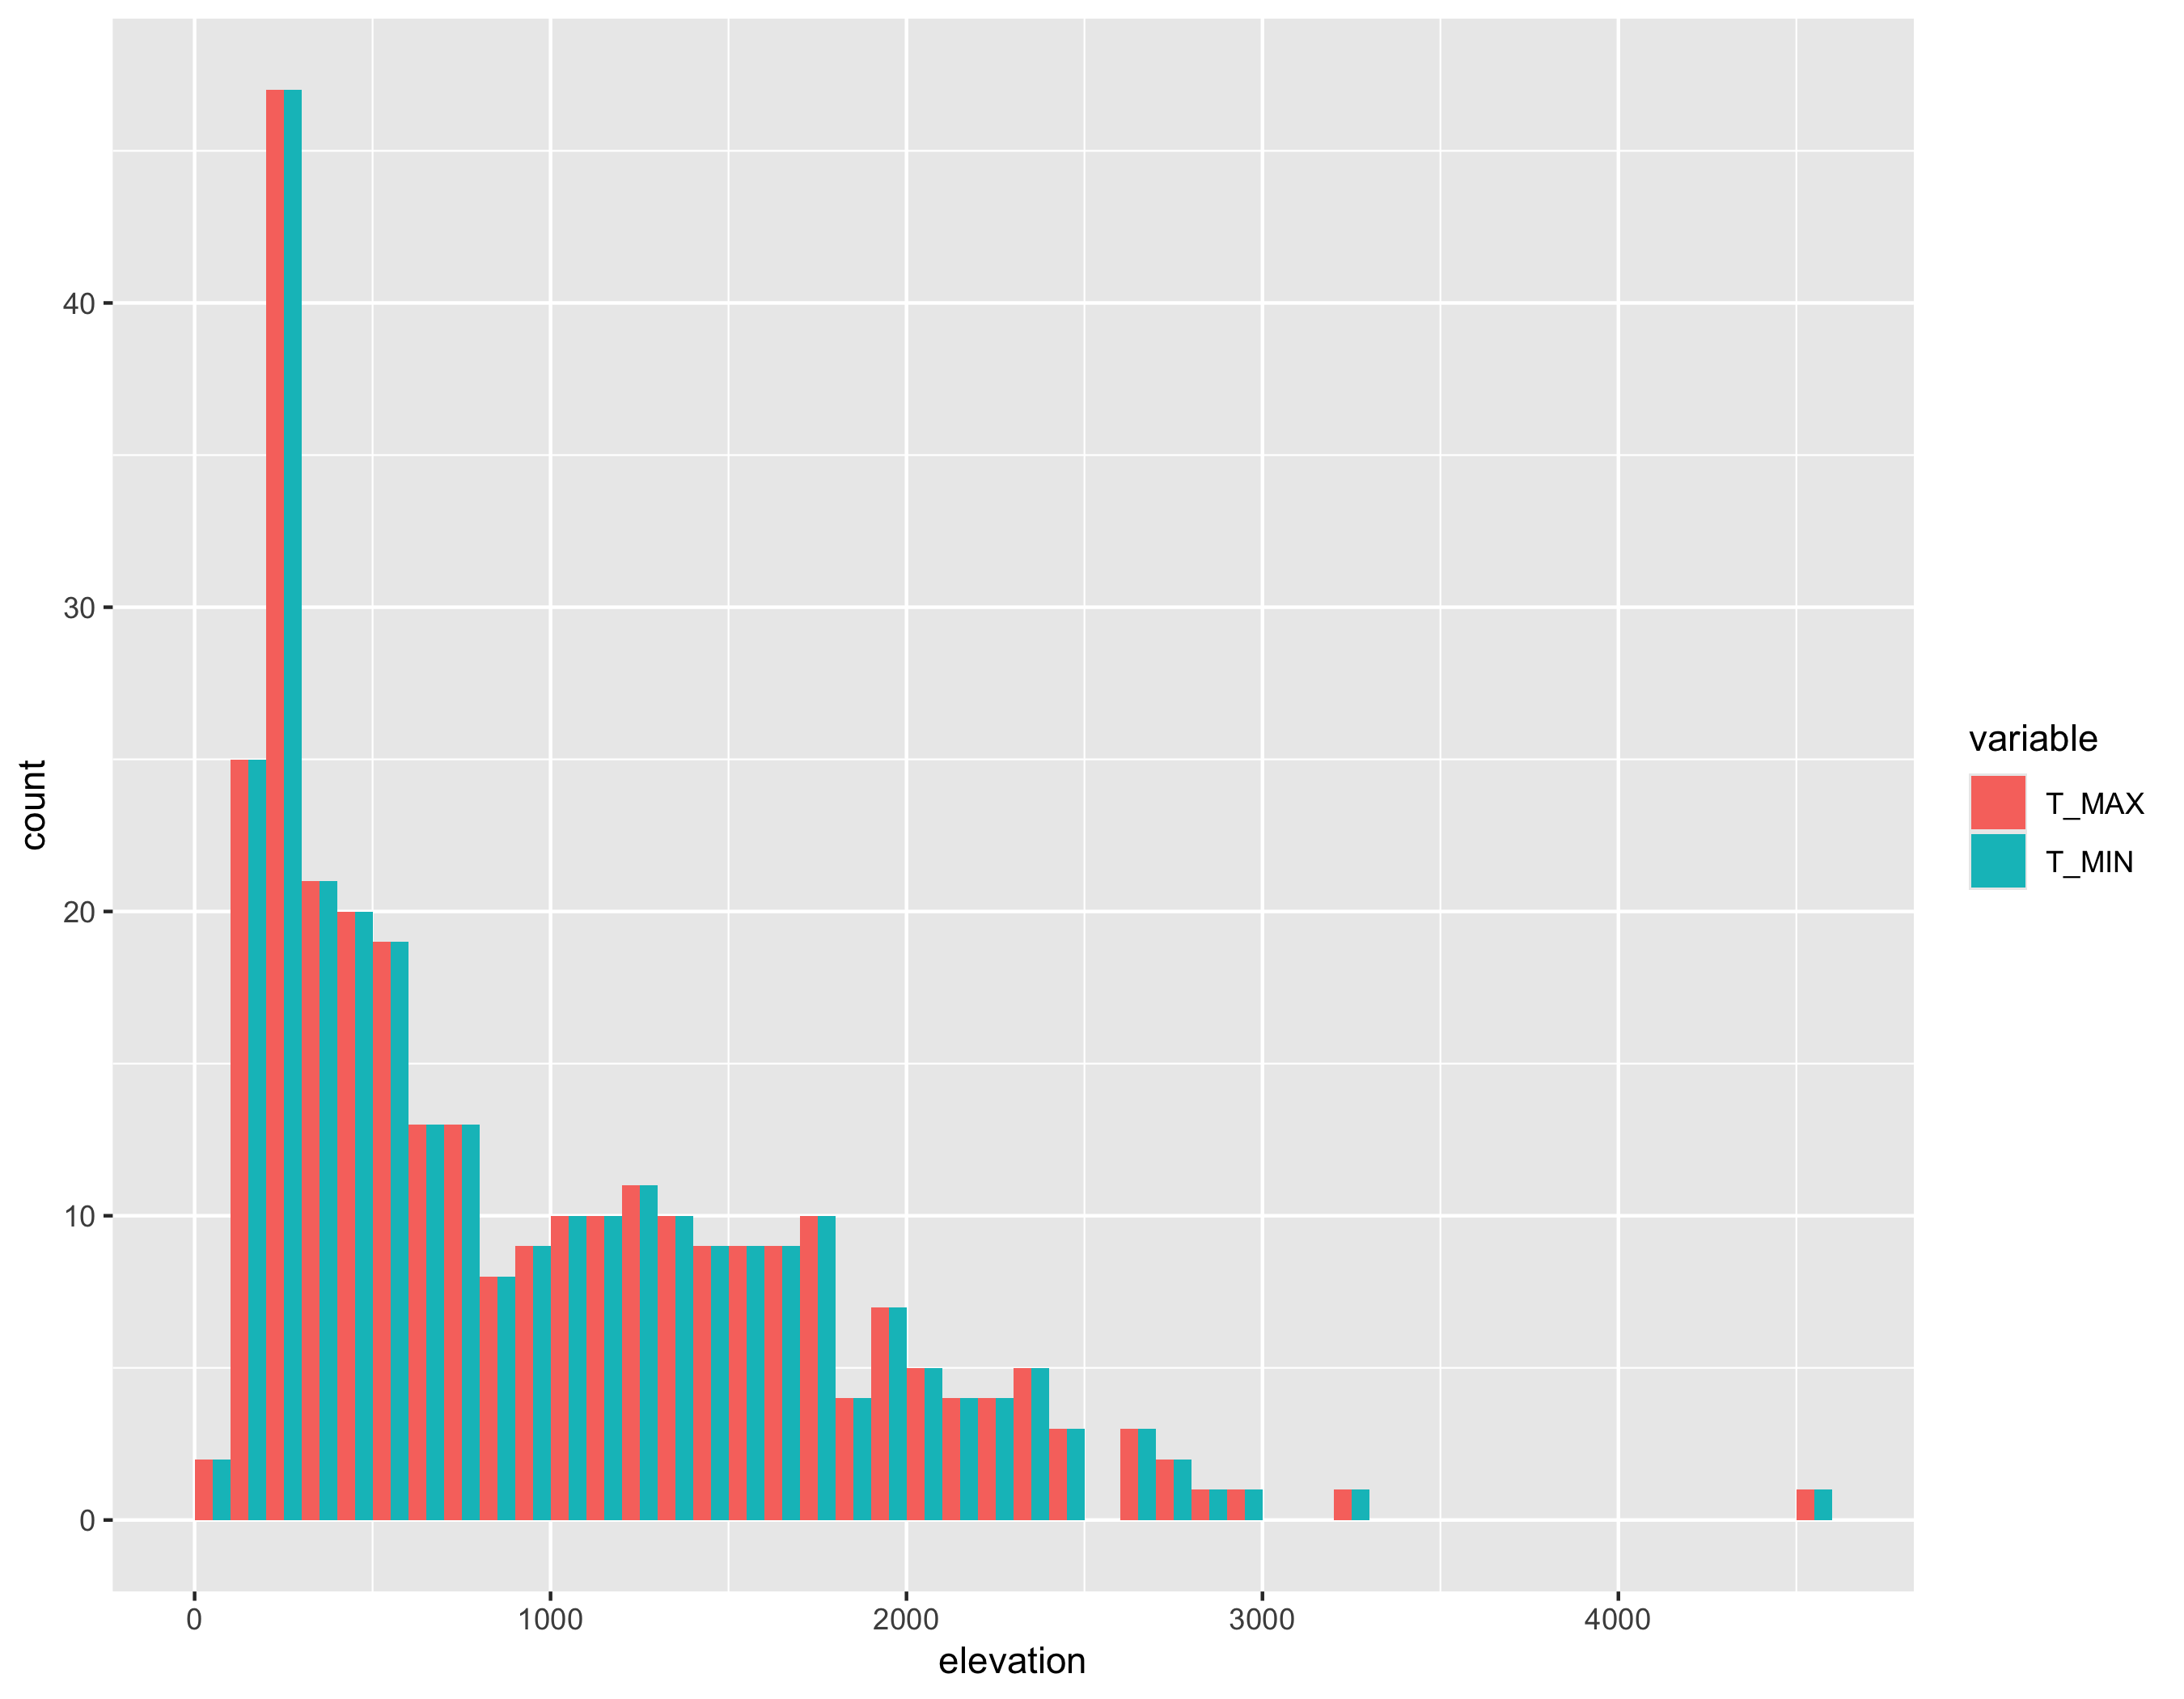

In [11]:
clim_availabilities <- pd$data |> mutate(dataset = new_dataset)
plot_available_by_elevation(clim_availabilities, db$meta |> collect())
